In [1]:
import laspy
import numpy as np
from sklearn import linear_model, decomposition
import open3d as o3d
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
def read_las_file(las_path):
    # Read the LAS file
    las_data = laspy.read(las_path)

    # Extract the points and classifications from the LAS file
    points = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()

    # Create an Open3D PointCloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    #return as point cloud
    return pcd


In [3]:
pcd = read_las_file("finalprojectdata.laz")

In [4]:
number_of_pts = len(pcd.points)
number_of_pts
#o3d.visualization.draw_geometries([pcd])

23299316

In [5]:
pcd_ref, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.2)
number_of_pts2 = len(pcd_ref.points)
print(f'Reduced the cloud size by: {round(number_of_pts/(number_of_pts + number_of_pts2)*100)}%')

Reduced the cloud size by: 57%


In [6]:
# Downsample cloud by voxelization
print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_ref, voxel_size=1.0)


voxelization


In [7]:
o3d.visualization.draw_geometries([voxel_grid])

In [8]:
points = np.asarray(pcd_ref.points)
voxel_size = voxel_grid.voxel_size

# Use defaultdict to store points temporarily
temp_voxel_points = defaultdict(list)

# Find the points inside each voxel
for point in points:
    voxel_index = tuple((np.floor(point / voxel_size)).astype(int))
    temp_voxel_points[voxel_index].append(point)

# Create final dictionary with only voxels having at least 10 points
voxel_points = {voxel_index: pts for voxel_index, pts in temp_voxel_points.items() if len(pts) >= 10}




In [9]:
num_of_voxels = len(voxel_points)
print(f'number of voxels: {num_of_voxels}')

pca = decomposition.PCA(n_components=3)
#create array to store values for all voxels
all_features = np.ones((num_of_voxels, 10 + 1)) # plus 1 to store voxel index

#test
print(len(list(voxel_points.keys())))

number of voxels: 522645
522645


In [10]:
def std_plane(points, voxel_size):
    # https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6

    # The centroid
    centroid = np.sum(points, axis=0)/points.shape[0]

    # Centered data
    c_data = points - centroid
    A = np.c_[c_data[:,0], c_data[:,1], np.ones(c_data.shape[0])]

    # Plane coefficients
    C,_,_,_ = np.linalg.lstsq(A, c_data[:,2], rcond=None)
    #       Z = C[0]*X + C[1]*Y + C[2]
    # =>    C[0]*X + C[1]*Y -1*Z + C[2] = 0

    # Distances from the plane
    distances = np.abs(C[0]*c_data[:,0] + C[1]*c_data[:,1] -1*c_data[:,2] + C[2]) / np.sqrt(C[0]**2 + C[1]**2 + 1)

    # Normalize distances
    distances /= voxel_size

    # Return the standard deviation
    return np.std(distances)



In [16]:
feature_dict = {}
#calculate PCA values for all voxels
for index, (key, values) in enumerate(voxel_points.items()):
    # Stack the arrays into a single 2D array
    all_points = np.stack(values)
    # Extract the z-values
    z_values = all_points[:, 2]
    
    pca.fit(all_points)
    explained_variance = pca.explained_variance_
    l1, l2, l3 = pca.explained_variance_
    #print(l1, l2, l3)

    sum_ev = explained_variance[0] + explained_variance[1] + explained_variance[2]
    L = (l1 - l2) / l1
    P = (l2 - l3) / l1
    S = l3 / l1
    O = (l1 * l2 * l3) ** (1 / 3)
    A = (l1 - l3) / l1
    E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
    change_curvature = l3 / l1+l2+l3
    z_range = np.max(z_values) - np.min(z_values)
    z_range = z_range / voxel_size
    plane_std = std_plane(points=all_points, voxel_size=1)

    feature_list = [L,P,S,O,A,E,change_curvature, z_range, plane_std, sum_ev]
    feature_dict[key] = feature_list

/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_93909/761633295.py:20: RuntimeWarning: divide by zero encountered in log
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_93909/761633295.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_93909/761633295.py:20: RuntimeWarning: divide by zero encountered in log
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))
/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_93909/761633295.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  E = -1 * ((l1 * np.log(l1)) + (l2 * np.log(l2)) + (l3 * np.log(l3)))


In [17]:
feature_dict

{(569749, 7033800, 9): [0.7991459407570122,
  0.1990034793765355,
  0.0018505798664523205,
  0.006213496614034345,
  0.9981494201335477,
  0.2833607801641344,
  0.019368005080367057,
  0.08999999999999986,
  0.004281409630166471,
  0.10393589738542279],
 (569750, 7033800, 8): [0.18798014767385637,
  0.8078264400029933,
  0.004193412323150415,
  0.012367795467185555,
  0.9958065876768496,
  0.38883213781714837,
  0.07129269409149863,
  0.129999999999999,
  0.010162332182952689,
  0.1493073083644108],
 (569751, 7033800, 8): [0.16950003698397018,
  0.8286169639994468,
  0.0018829990165830546,
  0.009828206317807639,
  0.9981170009834169,
  0.39712787187181076,
  0.07236326645489681,
  0.08000000000000007,
  0.006418082687371117,
  0.15515315318096107],
 (569752, 7033800, 8): [0.3658202263345217,
  0.6327991504353153,
  0.0013806232301629784,
  0.010893841322256254,
  0.998619376769837,
  0.4385745330823101,
  0.07375341930941241,
  0.129999999999999,
  0.0063250583102866164,
  0.186245209

In [14]:
all_features_df.rename(columns={0:'linearity', 1:'planarity',2:'scattering', 3:'omnivariance', 4:'anistropy', 5:'eigenentropy', 6:'change_curvature', 7:'z_range', 8:'plane_std', 9:'sum_ev'}, inplace=True)


/var/folders/5v/vnc_js6s26b4ryj6hnqj89bm0000gn/T/ipykernel_93909/3274669655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_features_df.rename(columns={0:'linearity', 1:'planarity',2:'scattering', 3:'omnivariance', 4:'anistropy', 5:'eigenentropy', 6:'change_curvature', 7:'z_range', 8:'plane_std', 9:'sum_ev'}, inplace=True)


In [18]:
df = pd.DataFrame.from_dict(feature_dict, orient='index', columns=['linearity','planarity','scattering', 'omnivariance', 'anistropy', 'eigenentropy', 'change_curvature', 'z_range', 'plane_std', 'sum_ev'])
#features_and_point_df = df[(af[0] != 1) & (af[1] != 1) & (af[2] != 1) & (af[3] != 1)]
#features_and_point_df
df


,linearity,planarity,scattering,omnivariance,anistropy,eigenentropy,change_curvature,z_range,plane_std,sum_ev
"(569749, 7033800, 9)",0.79915,0.19900,0.00185,0.00621,0.99815,0.28336,0.01937,0.09000,0.00428,0.10394
"(569750, 7033800, 8)",0.18798,0.80783,0.00419,0.01237,0.99581,0.38883,0.07129,0.13000,0.01016,0.14931
"(569751, 7033800, 8)",0.16950,0.82862,0.00188,0.00983,0.99812,0.39713,0.07236,0.08000,0.00642,0.15515
"(569752, 7033800, 8)",0.36582,0.63280,0.00138,0.01089,0.99862,0.43857,0.07375,0.13000,0.00633,0.18625
"(569753, 7033800, 8)",0.34611,0.65268,0.00121,0.01061,0.99879,0.44412,0.07642,0.11000,0.00717,0.19002
...,...,...,...,...,...,...,...,...,...,...
"(570240, 7034353, 12)",0.57035,0.40187,0.02778,0.02306,0.97222,0.38399,0.07394,0.46000,0.03321,0.14708
"(570239, 7034352, 12)",0.47688,0.45797,0.06515,0.03742,0.93485,0.45549,0.13306,0.65000,0.04997,0.18333
"(570238, 7034351, 12)",0.50010,0.47551,0.02439,0.02047,0.97561,0.36689,0.07102,0.30000,0.03493,0.13554
"(570223, 7034319, 37)",0.78426,0.20431,0.01142,0.01503,0.98858,0.34229,0.03669,0.57000,0.01920,0.13652


array([[<Axes: title={'center': 'linearity'}>,
        <Axes: title={'center': 'planarity'}>,
        <Axes: title={'center': 'scattering'}>],
       [<Axes: title={'center': 'omnivariance'}>,
        <Axes: title={'center': 'anistropy'}>,
        <Axes: title={'center': 'eigenentropy'}>],
       [<Axes: title={'center': 'change_curvature'}>,
        <Axes: title={'center': 'z_range'}>,
        <Axes: title={'center': 'plane_std'}>],
       [<Axes: title={'center': 'sum_ev'}>, <Axes: >, <Axes: >]],
      dtype=object)

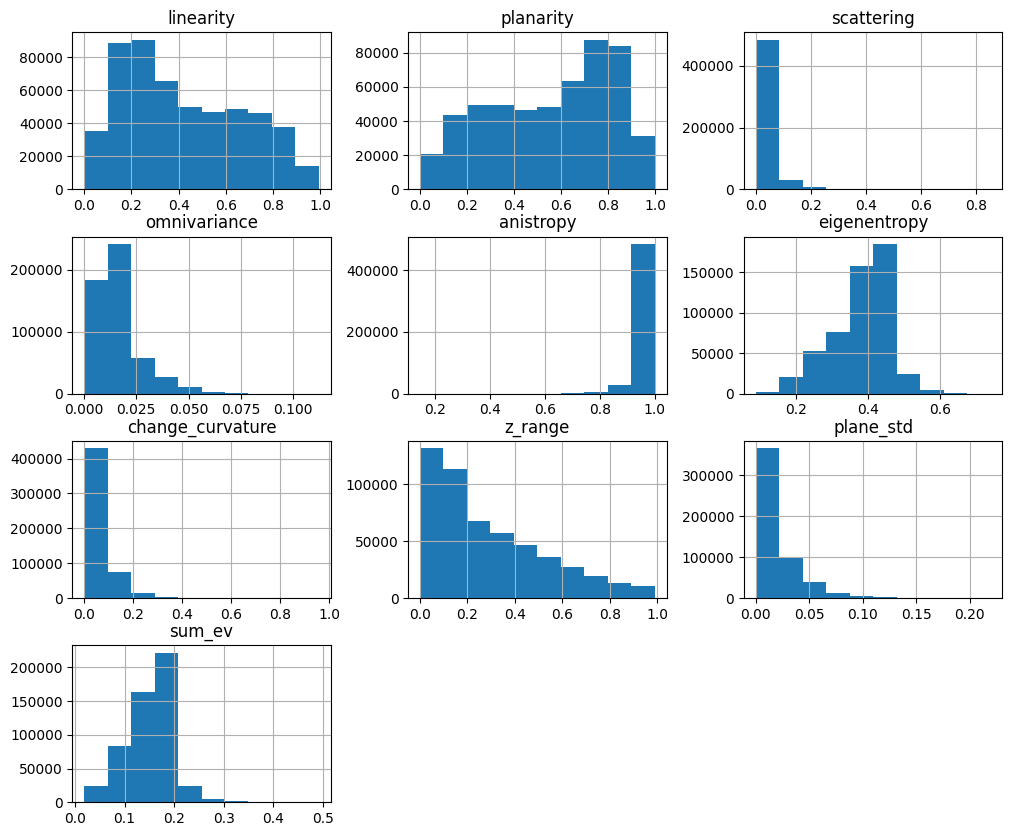

In [19]:
df.hist(figsize=(12,10))

In [20]:
# Access a random row
random_row = df.sample()
print(f'random selected row: {random_row}')
random_voxel_idx = random_row.index[0]

inlier_points = voxel_points[random_voxel_idx]
inlier_points_array = np.stack(inlier_points)

o3dvoxel = o3d.geometry.PointCloud()
o3dvoxel_elevated = o3d.geometry.PointCloud()

o3dvoxel.points = o3d.utility.Vector3dVector(inlier_points_array)
o3dvoxel_elevated.points = o3d.utility.Vector3dVector(inlier_points_array[:,:3]+[0,0,100])

o3dvoxel_elevated.paint_uniform_color([1,0,0])
o3dvoxel.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([o3dvoxel, o3dvoxel_elevated, pcd_ref])

random selected row:                       linearity  planarity  scattering  omnivariance  \
(569941, 7034070, 9)    0.48956    0.50593     0.00451       0.01503   

                      anistropy  eigenentropy  change_curvature  z_range  \
(569941, 7034070, 9)    0.99549       0.41656           0.06312  0.23000   

                      plane_std  sum_ev  
(569941, 7034070, 9)    0.01440 0.17243  


In [92]:
# Access a random row
random_row = df.sample()
#print(f'random selected row: {random_row}')
random_voxel_idx = random_row.index[0]


# Assuming voxel_size is known, and random_voxel_idx is the center of the voxel
voxel_center = np.array(voxel_points[random_voxel_idx][0])
half_size = 20  # Half the size of the bounding box

# Create a bounding box
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=voxel_center - half_size,
                                           max_bound=voxel_center + half_size)

# Extract points within the bounding box from the original point cloud
points_o3d = o3d.utility.Vector3dVector(np.asarray(pcd_ref.points))  # Convert to Vector3dVector
inlier_indices = bbox.get_point_indices_within_bounding_box(points_o3d)
inlier_points_array_bb = np.asarray(pcd_ref.points)[inlier_indices]

# Create a PointCloud for visualization
subchunk = o3d.geometry.PointCloud()
subchunk.points = o3d.utility.Vector3dVector(inlier_points_array_bb)
subchunk.paint_uniform_color([0,0,0])

# visualize the voxel
inlier_points = voxel_points[random_voxel_idx]
inlier_points_array = np.stack(inlier_points)
o3dvoxel = o3d.geometry.PointCloud()
o3dvoxel.points = o3d.utility.Vector3dVector(inlier_points_array)
o3dvoxel.paint_uniform_color([0,1,0])


# Visualize
o3d.visualization.draw_geometries([subchunk, o3dvoxel])  


In [94]:
tree_indices = [(570368, 7034210, 54),(570083, 7034144, 27), (569803, 7033919, 33), (569739, 7034333, 17), (570349, 7034136, 53), (570236, 7034122, 36), (570074, 7033931, 34) ]
building_indices = [ (569776, 7034285, 22), (569911, 7034328, 16), (570227, 7034315, 22), (570031, 7034021, 12), (569820, 7034360, 24), (569600, 7034260, 26) ]
terrain_indices = [ (570261, 7033803, 23), (569638, 7034074, 12), (570134, 7034127, 27), (569772, 7034144, 10), (569663, 7034285, 9), (570171, 7034219, 21), (570241, 7033933, 29), (570127, 7033856, 16), (570095, 7033847, 9)]

In [96]:
# Function to calculate the average for each column based on indices
def calculate_average(df, indices):
    filtered_df = df.loc[indices]
    return filtered_df.mean()

# Calculate averages
average_trees = calculate_average(df, tree_indices)
average_buildings = calculate_average(df, building_indices)
average_terrain = calculate_average(df, terrain_indices)

# Display the averages
print("Average for Trees:\n", average_trees)
print()
print("Average for Buildings:\n", average_buildings)
print()
print("Average for Terrain:\n", average_terrain)
print()

Average for Trees:
 linearity          0.60925
planarity          0.31725
scattering         0.07350
omnivariance       0.02462
anistropy          0.92650
eigenentropy       0.34206
change_curvature   0.11244
z_range            0.43286
plane_std          0.04282
sum_ev             0.12579
dtype: float64

Average for Buildings:
 linearity          0.55365
planarity          0.44213
scattering         0.00421
omnivariance       0.01171
anistropy          0.99579
eigenentropy       0.36581
change_curvature   0.04928
z_range            0.42667
plane_std          0.01210
sum_ev             0.14548
dtype: float64

Average for Terrain:
 linearity          0.45208
planarity          0.53791
scattering         0.01001
omnivariance       0.01670
anistropy          0.98999
eigenentropy       0.41293
change_curvature   0.07142
z_range            0.28444
plane_std          0.01522
sum_ev             0.17456
dtype: float64



In [97]:
average_trees

linearity          0.60925
planarity          0.31725
scattering         0.07350
omnivariance       0.02462
anistropy          0.92650
eigenentropy       0.34206
change_curvature   0.11244
z_range            0.43286
plane_std          0.04282
sum_ev             0.12579
dtype: float64

In [117]:

# Define a threshold for closeness
threshold = 0.40  # This is an example threshold, adjust it as needed

# Function to check if values are within the threshold of the average
def is_close_to_average(row, average, threshold):
    return all(abs(row[col] - average[col]) <= threshold * average[col] for col in average.index)

# List to store indices of rows close to the average
close_indices = []

# Iterate over each row in the DataFrame
for idx, row in df.iterrows():
    if is_close_to_average(row, average_buildings, threshold):
        close_indices.append(idx)

# close_indices now contains the indices of rows close to the average for trees


In [118]:
len(close_indices)

10970

In [119]:
# find interest points from voxels with similar features:
interest_points = o3d.geometry.PointCloud()
for index in close_indices:
   
    points = voxel_points[index]
    tmp_cloud = o3d.geometry.PointCloud()
    tmp_cloud.points = o3d.utility.Vector3dVector(np.stack(points))
    interest_points += tmp_cloud



# Visualize pont clouds
interest_points.paint_uniform_color([1,0,0])
pcd_ref.paint_uniform_color([0,0,0])
o3d.visualization.draw_geometries([pcd_ref, interest_points]) 

    